# Cohort 분석 
- 분석을 위한 Dataset으로 Kaggle의 https://archive.ics.uci.edu/ml/datasets/Online+Retail# 사용하여 Notebook을 통해 분석을 진행해보았다.

- Time Cohort는 특정 기간 동안 제품이나 서비스를 등록하거나 이용한 소비자들에게 진행하며 월, 분기, 심지어 일까지도 기간을 정해서 사용한다. 
- Behaovior cohorts는 과거에 제품을 구매하거나 서비스를 구독한 소비자들에 대해 서비스 유형별로 고객을 그룹화한다. 서비스 구매 수준에 따라서 요구사항과 고객의 특성이 다르며 다양한 그룹의 욕를 이해하며 특정 부문에 맞춤형 서비스를 제공하거나 제품을 설계하는데 사용한다. 

- Size cohorts 는 회사의 제품이나 서비스를 구매하는 다양한 규모의 소비자를 의미한다. 일정 기간 동안 지출한 금액 또는 고객이 일정 기간 동안 대부분의 주문 금액을 지출한 제품 유형을 기반으로 할 수 있다. 


## Dataset EDA

In [2]:
# 기본 Library 
import numpy as np
import pandas as pd
import datetime as dict
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_excel('data/Online Retail.xlsx')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# 기본적인 Columns 정보 확인하기
# Description, CustomerID에 결측값이 존재한다.
# 총 7개의 컬럼 
# Invoice : 주문 
# StockCode : 제품 번호
# Description : 제품 설명
# Quantity : 양
# InvoiceDate : 주문일자
# UnitPrice : 제품당 가격
# CustomerID : 회원ID
# Country : 지역 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# 결측치 확인하기
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# CustomerID의 결측값 제거하기
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
# 중복확인하기
df.duplicated().sum()

5225

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
# Columns의 정보를 확인한다.
# 정보를 확인한 결과 UnitPrice의 최소 가격이 0인 경우는 존재하지 않으며
# Quantity의 -80995또한 0미만의 값이 나올 수 없다. 
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
# Quantity와 UnitPrice의 0이하인 값들을 제거한다. 
df = df[(df['Quantity'] > 0) & (df['UnitPrice']>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [12]:
df.shape

(392692, 8)

# Cohort 분석 시작
- Cohorts 분석을 하기 전 몇가지 Labels들을 만들어야 한다.
- invoice period : invoice/transaction에 대한 연-월 
- cohort group : 고객의 첫 구매 연-월, 
- cohort period & cohort index : 고객의 단계와 liftetime을 숫자형으로 표현하며 첫 구매로 얼마나 지났는지를 알려준다. 


In [13]:
# datetime 함수를 통해서 year, month return
def get_month(x) : return dt.datetime(x.year, x.month, 1)


In [14]:
# get_month함수를 적용
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
# CustomerID를 기준으로 InvocieMonth Groupby
grouping = df.groupby('CustomerID')['InvoiceMonth']
# grouping에 대해서 Min값을 통해 첫번쨰 구매 찾기 
df['CohortMonth'] = grouping.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [15]:
# dataframe과 column의 year, month, day를 return하는 함수
def get_month_int (dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

# 년, 월을 저장한다.
invoice_year, invoice_month,_ = get_month_int(df, 'InvoiceMonth')
cohort_year, cohort_month,_ = get_month_int(df,'CohortMonth')

# 주문년월 - 첫 주문 년월
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

# 동일 년도일 경우에는 0, 아닐 경우에는 12를 곱해서 월, 
# 만약 같은 월일 경우에 +1을 해주는 이유는 1부터 시작하는 개월
df['CohortIndex'] = year_diff * 12 + month_diff + 1

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [16]:
# 각각의 cohort에 대한 월별 고객 행동

# CohortMonth와 CohortIndex를 Grouping
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

# Cohort Month, CohortIndex로 Grouping 된 CustomerID의 유일한 값 수 찾기
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# reset_index를 통해서 DF화 해주기
cohort_data = cohort_data.reset_index()

# pivot을 사용해서 구매 년월과 첫 구매 년월의 차이를 나타내는 CohortIndex를 Column으로 
# dataframe 생성하기
cohort_counts = cohort_data.pivot(index='CohortMonth', columns = 'CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Retention Rate Table

cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size, axis=0)
retention.round(3) * 100 


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


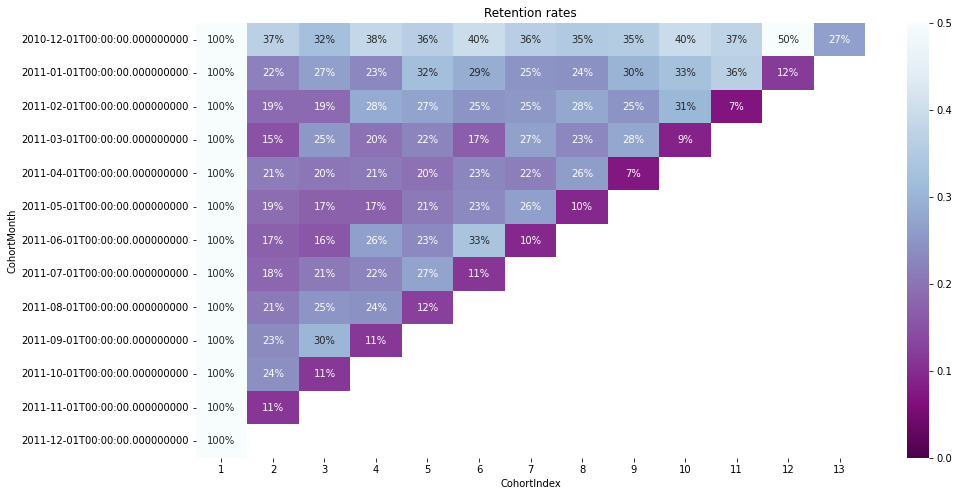

In [18]:
# Heatmap 
plt.figure(figsize=(15,8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuPu_r')
plt.show()

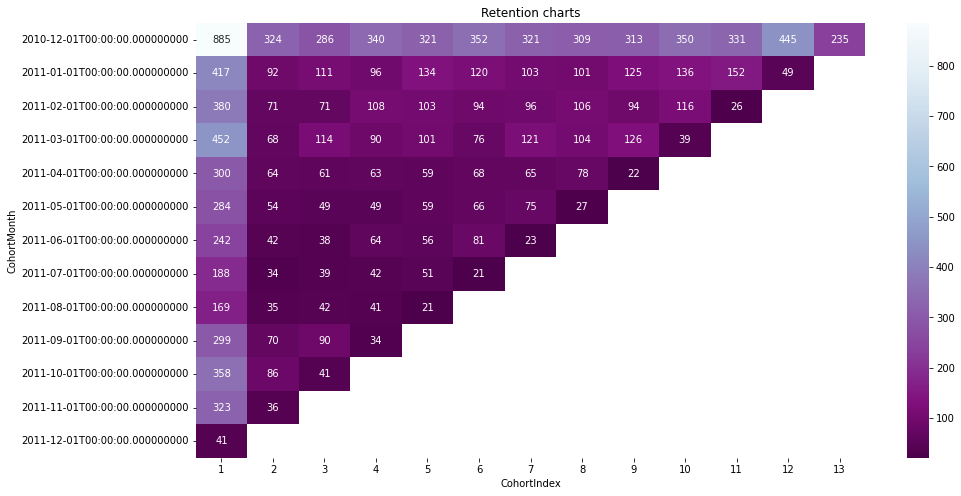

In [23]:
plt.figure(figsize=(15,8))
plt.title('Retention charts')
sns.heatmap(data=cohort_counts, annot=True,fmt='g', cmap='BuPu_r')
plt.show()

In [ ]:
# 1월에 처음 구매한 고객들은 뒤로 가더라도 꾸준한 구매%를 보여주고 있으며 6월, 10월, 12월에는 특히 40%를 넘어가는 %를 보여준다.
# 하지만 문제가 되는점은 1월에 첫구매를 한 고객들에게만 다음달, 및 지속적인 구매 %가 높으며 월이 바뀔수록 구매%가 낮아지는 것을 확인할 수 있다. 
# 하지만 위에서 %로 봤듯이 6월, 10월에는 마케팅 및 여러가지 요인의 성공으로 인해서 다른 달의 구매고객도 재 구매비율이 높은것을 알 수 있다. 
# 신규 가입자의 수는 2010년 12월에 비해서 지속적으로 감소하고 있으나 2011년 9월을 기점으로 다시 증가하는 추세이나 
# 2011년 4월 가입자 이후 부터 재구매율에 대한 비율 및 양은 너무 낮다.

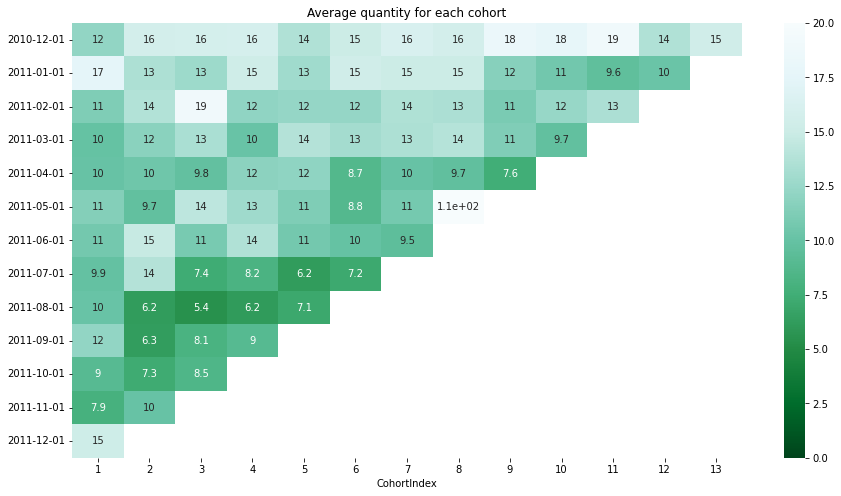

In [24]:
# 응용해보기
# Cohort별 월 구매 건수가 아닌 평균 구매 량 확인하기
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()